In [37]:
using LinearAlgebra, Plots, Random, RxInfer, StableRNGs

# Batch linear regression

Given data $\{ (t_k, y_k) \}_{k=1}^T$, we form a linear regression model

$$y_k = \theta_0 + \theta_1 t_k + \epsilon_k$$

where
 - $\pmb{\theta} = [\theta_0, \theta_1]^\top$ are parameters
 - $\epsilon_k \sim \mathcal{N}(0, \sigma^2)$ are independent additive noise terms with a known variance $\sigma^2$

By defining $\mathbf{H}_k := \begin{bmatrix}1 & t_k \end{bmatrix}$, this can be written:

$$y_k \sim \mathcal{N}(\mathbf{H}_k \theta, \sigma^2)$$

We establish a prior over parameters using an assumed mean and variance $\mathbf{m}_0$, $\mathbf{P}_0$:

$$\mathbf{\theta} \sim \mathcal{N}(\mathbf{m}_0, \mathbf{P}_0)$$

In [109]:
function make_linear_gaussian(a, b, v, x, rng)
    num_samples = length(x)
    y = a .+ b .* x .+ randn(rng, num_samples) * sqrt(v)
    return x, y
end

make_linear_gaussian (generic function with 1 method)

In [167]:
seed = 299792458
m0 = [10;5]
P0 = Diagonal([30, 10])
rng = StableRNG(seed)

β = [25.0, 0.5]
var_y = 1.0
ts = float.(rand(1:100, 5))
ts, ys = make_linear_gaussian(β[1], β[2], var_y, ts, rng);

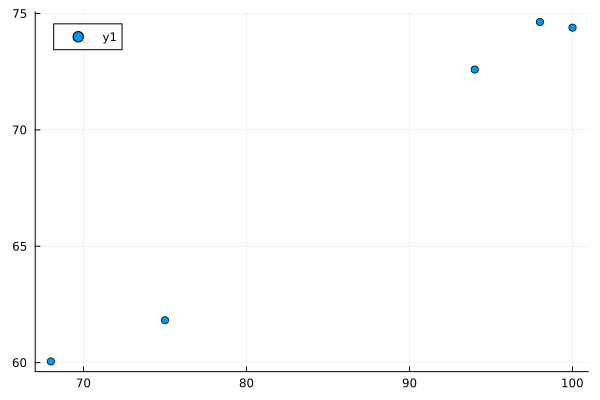

In [168]:
scatter(ts, ys)

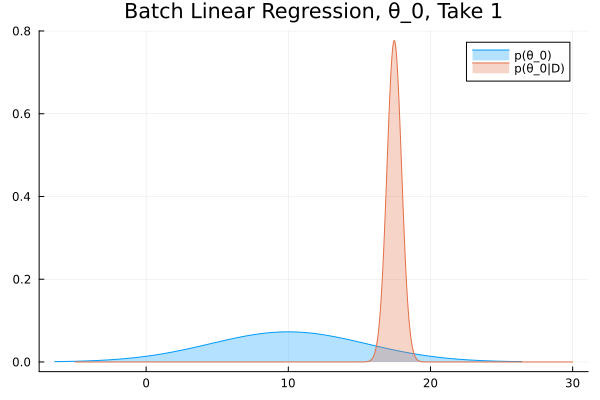

In [199]:
@model function batch_lin_reg_1(n, mu_theta0, var_theta0, mu_theta1, var_theta1, var_y)
    theta0 ~ Normal(mean = mu_theta0, variance = var_theta0)
    theta1 ~ Normal(mean = mu_theta1, variance = var_theta1)
    
    t = datavar(Float64, n)
    y = datavar(Float64, n)
    
    y .~ Normal(mean = theta0 .+ theta1 .* t, variance = var_y)
end

blr1_result = infer(
    model = batch_lin_reg_1(length(ys), m0[1], P0[1,1], m0[2], P0[2,2], var_y), 
    data  = ( t = ts, y = ys, ),
    initmessages = (theta1 = NormalMeanVariance(m0[2], P0[2,2]),),
    iterations = 20,
    returnvars   = (theta0 = KeepLast(), theta1 = KeepLast()),
    free_energy  = true
)

three_sigma_range(μ, σ2) = [μ - 3 * sqrt(σ2), μ + 3 * sqrt(σ2)]

plot(title="Batch Linear Regression, θ_0, Take 1")
th0_prior = NormalMeanVariance(m0[1], P0[1,1])
th0_xs = range(three_sigma_range(m0[1], P0[1,1])..., length = 1000)
plot!(th0_xs, (x) -> pdf.(th0_prior, x), fillalpha=0.3, fillrange=0, label="p(θ_0)", c=1)
th0_posterior = blr1_result.posteriors[:theta0]
plot!(range(-5, 30, length=1000), (x) -> pdf(th0_posterior, x), fillalpha=0.3, fillrange = 0, label="p(θ_0|D)", c=2)

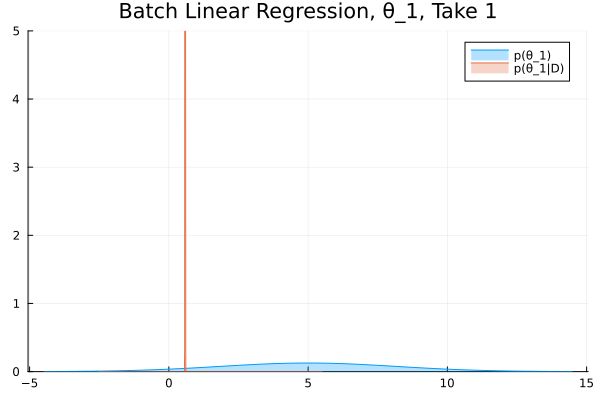

In [173]:
plot(title="Batch Linear Regression, θ_1, Take 1")
th1_prior = NormalMeanVariance(m0[2], P0[2,2])
th1_xs = range(three_sigma_range(m0[2], P0[2,2])..., length = 1000)
plot!(th1_xs, (x) -> pdf.(th1_prior, x), fillalpha=0.3, fillrange=0, label="p(θ_1)", c=1)
th1_posterior = blr1_result.posteriors[:theta1]
plot!(range(-2.5, 5.5, length=1000), (x) -> pdf(th1_posterior, x), fillalpha=0.3, fillrange = 0, label="p(θ_1|D)", c=2)
ylims!(0, 5)

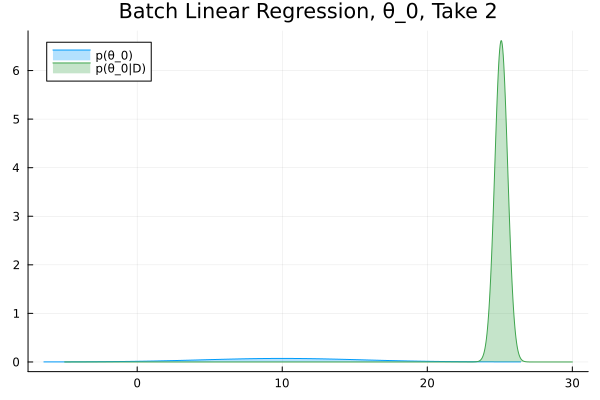

In [205]:
@model function batch_lin_reg_2(n, m0, P0, var_y)
    theta ~ MvNormalMeanCovariance(m0, P0)
    
    H = datavar(Vector{Float64}, n)
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ Normal(mean = dot(H[i], theta), variance = var_y)
    end
end

H = map((t) -> [1; t], ts)

blr2_result = infer(
    model = batch_lin_reg_2(length(ys), m0, P0, var_y), 
    data  = ( H = H, y = ys, ),
    free_energy  = true
)

plot(title="Batch Linear Regression, θ_0, Take 2")
th0_prior = NormalMeanVariance(m0[1], P0[1,1])
th0_xs = range(three_sigma_range(m0[1], P0[1,1])..., length = 1000)
plot!(th0_xs, (x) -> pdf.(th0_prior, x), fillalpha=0.3, fillrange=0, label="p(θ_0)", c=1)
th0_posterior = blr2_result.posteriors[:theta]
plot!(range(-5, 30, length=1000), (x) -> pdf(th0_posterior, [x, 0.5]), fillalpha=0.3, fillrange = 0, label="p(θ_0, θ_1 = 0.5|D)", c=3)

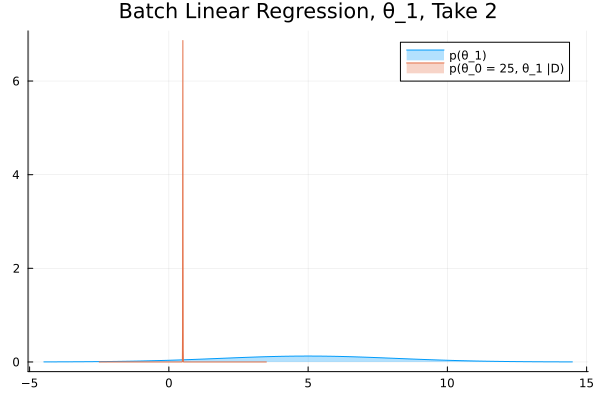

In [208]:
plot(title="Batch Linear Regression, θ_1, Take 2")
th1_prior = NormalMeanVariance(m0[2], P0[2,2])
th1_xs = range(three_sigma_range(m0[2], P0[2,2])..., length = 1000)
plot!(th1_xs, (x) -> pdf.(th1_prior, x), fillalpha=0.3, fillrange=0, label="p(θ_1)", c=1)
th0_posterior = blr2_result.posteriors[:theta]
plot!(range(-2.5, 3.5, length=1000), (x) -> pdf(th0_posterior, [25.0, x]), fillalpha=0.3, fillrange = 0, label="p(θ_0 = 25, θ_1 |D)", c=2)